# AR/MA processes as as state-space models

In [14]:
import jax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

sns.set_palette("colorblind")

In [3]:
def step(x, key, F, H, T):
    et = jax.random.normal(key, (1,1)) * w0
    y = H @ x + et # y(t)
    z = F @ x + T @ et # z(t+1)

    out = {
        "y": y,
        "z": z
    }
    
    return z, out

## MA(m) process

A time series $y_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\,\times\,p$ matrices $A_1, \ldots, A_m$ such that
$$
    y_t = \sum_{j=1}^m A_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm MA}\,{\bf z}_t + {\bf e}_t\\
    {\bf z}_{t+1} &= {\bf F}_{\rm MA}\,{\bf z}_t + {\bf T}_m\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$

and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

### Building blocks

In [4]:
A = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0]) 
A = -jnp.ones(10)
m = len(A.squeeze())

In [5]:
Fma = jnp.r_[
    jnp.zeros((1, m-1)),
    jnp.eye(m-1)
]
Fma = jnp.c_[Fma, jnp.zeros(m)]
Fma

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [6]:
Tm = jnp.zeros((m,1)).at[0].set(1)
Tm

Array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

### Sampling

In [7]:
key = jax.random.PRNGKey(314)

In [8]:
n_samples = 100

In [9]:
step_ma = partial(step, F=Fma, H=A, T=Tm)

In [10]:
w0 = 0.1 ** 2 # measurement noise
z0 = jnp.zeros((m, 1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_ma, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

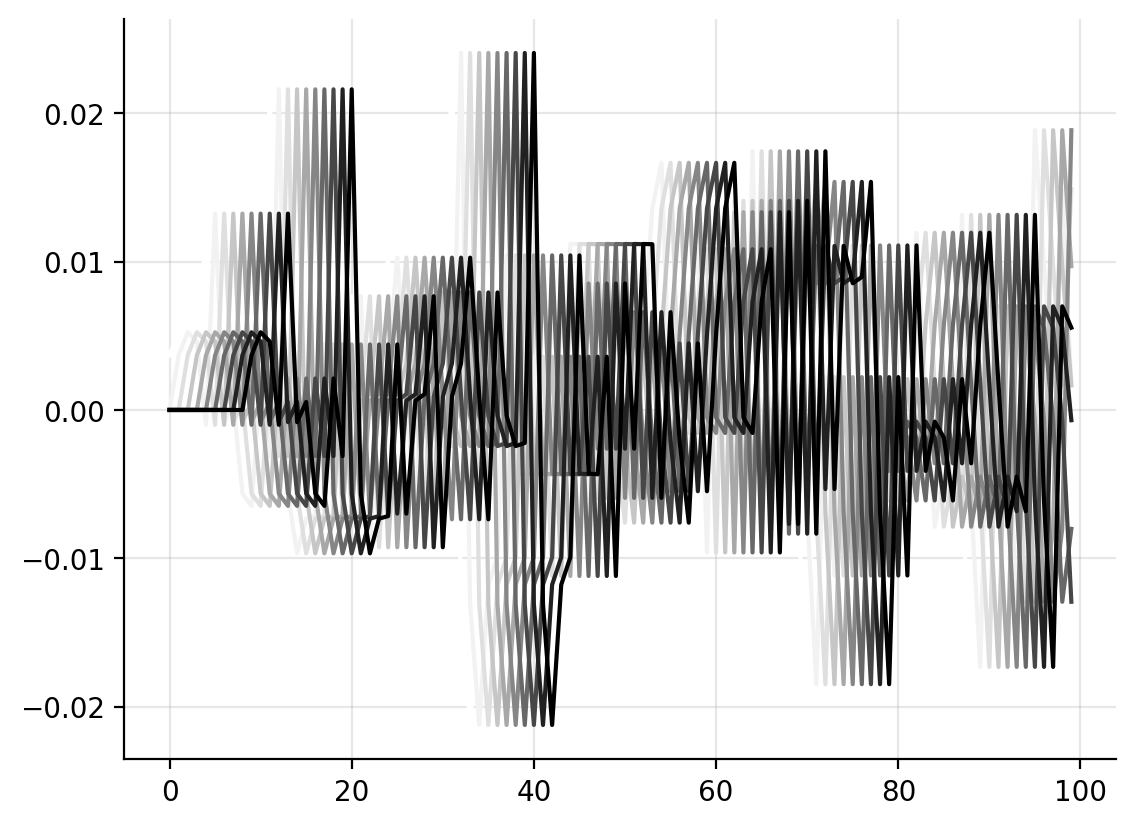

In [11]:
colors = plt.cm.Grays(jnp.linspace(0, 1, m))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

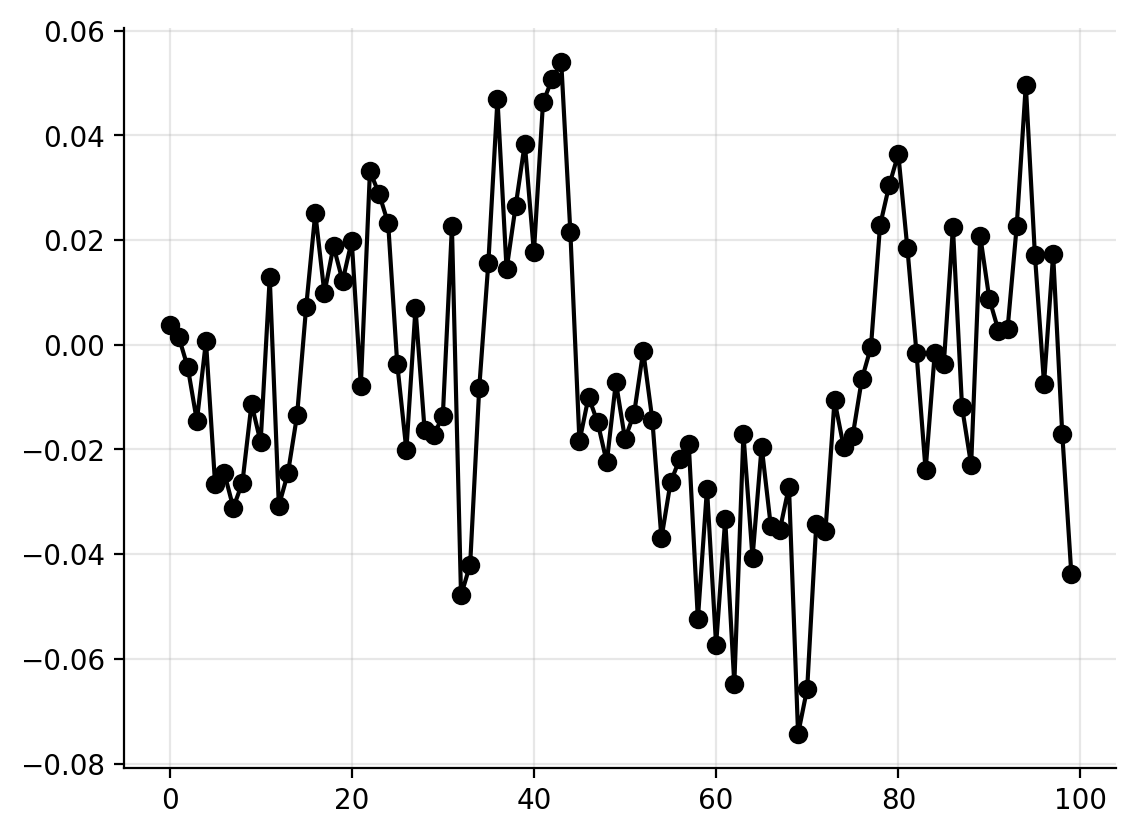

In [12]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

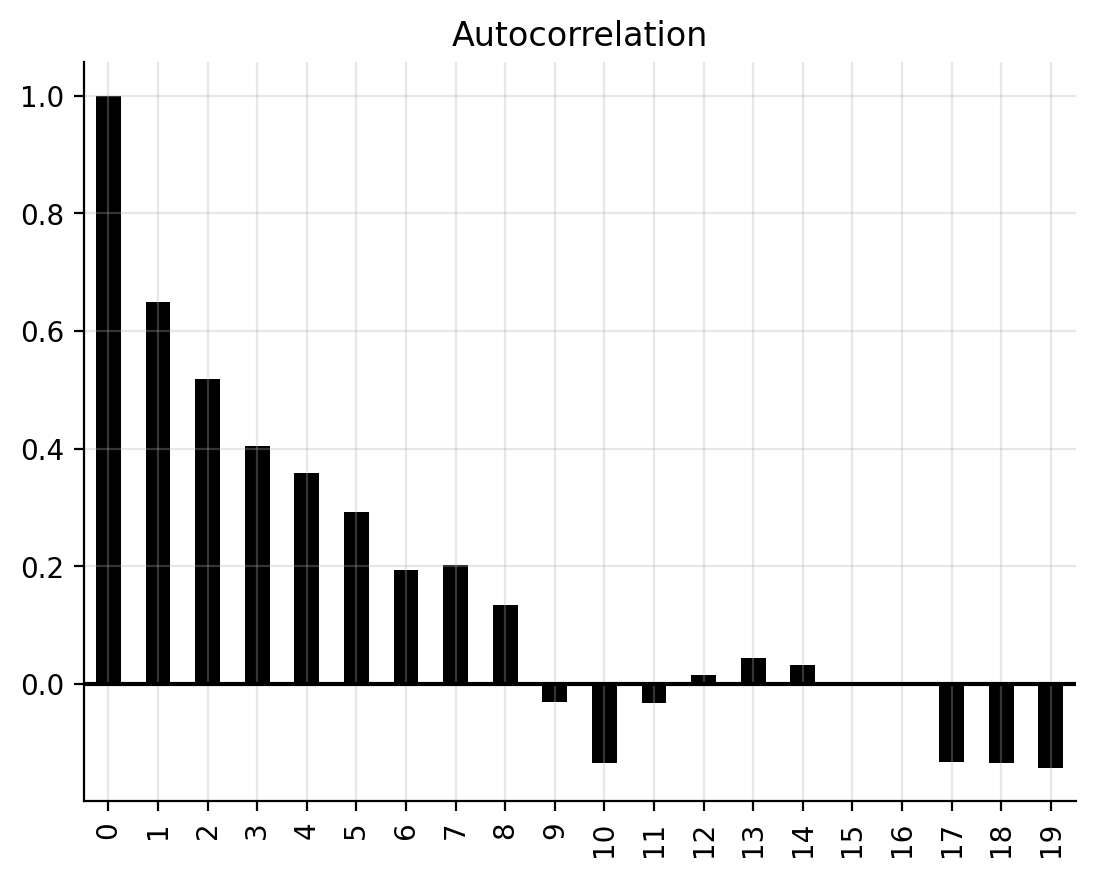

In [15]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.title("Autocorrelation")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## AR(r) process

An $r$th order autoregressive (AR) process has the form
$$
    y_t = \sum_{j=1}^r B_j\,y_{t-j} + e_t
$$
with $B_1, \ldots, B_r$ known coefficient matrices, $e_{1:t}$ zero-mean blockwise uncorrelated random vectors
and $y_{-1} = \ldots = y_{-r} = 0$.

In state-space form, the MA(p) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm AR}{\bf z}_t + {\bf e}_t\\
    {\bf z}_{t+1} &= {\bf F}_{\rm AR}{\bf z}_t + {\bf T}_r\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{MA} =
    \begin{bmatrix}
    {\bf B}_1 & \ldots & {\bf B}_{r-1} & {\bf B}_r\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and
$$
    {\bf H}_{\rm MA} =
    \begin{bmatrix}
    {\bf B}_1, \ldots, {\bf B}_r
    \end{bmatrix}
$$

In [57]:
B = jnp.array([[0.1, 0.2, -0.3, -0.5]])
B = jnp.array([[1.0, -1.0, 1.0, -1.0]])
r = len(B.ravel())

In [58]:
n_samples = 100

In [59]:
Far = jnp.r_[
    B,
    jnp.eye(r)
]
Far = Far[:-1, :]

In [60]:
Tr = jnp.zeros((r,1)).at[0].set(1)
Tr

Array([[1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [61]:
step_ar = partial(step, F=Far, H=B, T=Tr)

In [62]:
w0 = 0.1 ** 2 # measurement noise
z0 = jnp.zeros((r,1))

keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step_ar, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

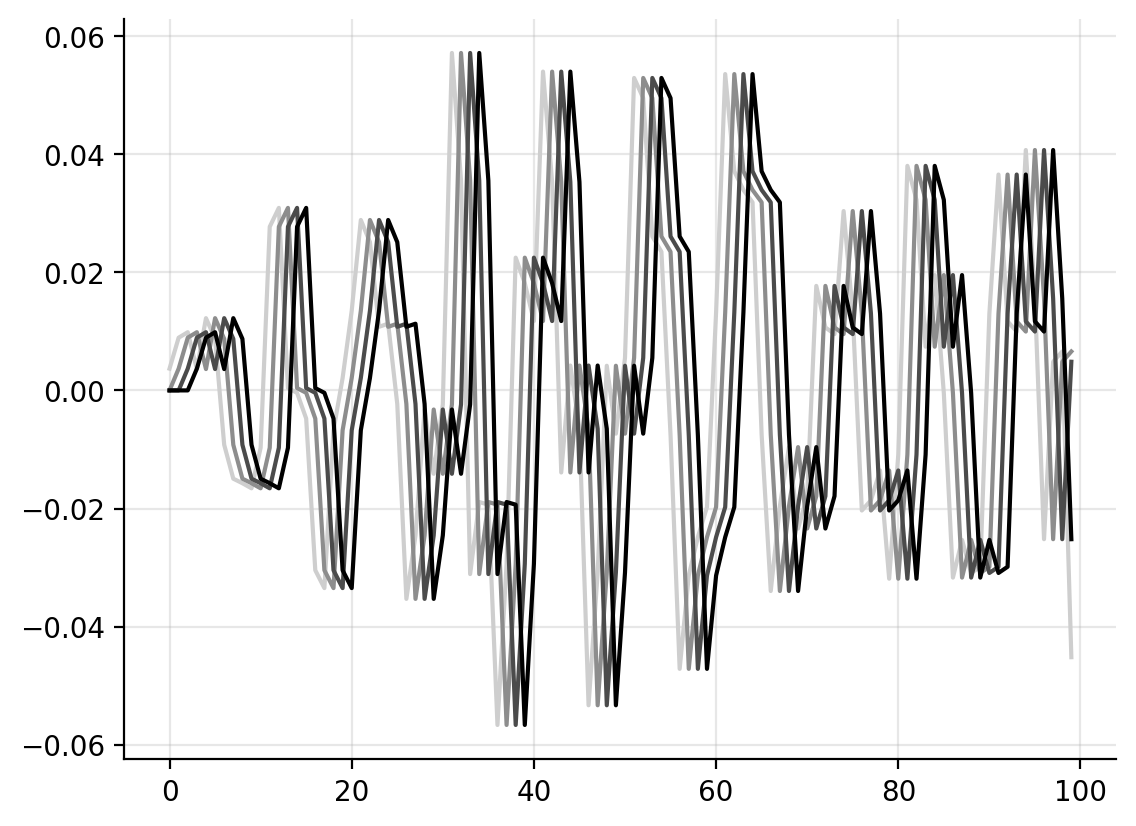

In [63]:
colors = plt.cm.Greys(jnp.linspace(0.3, 1, r))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

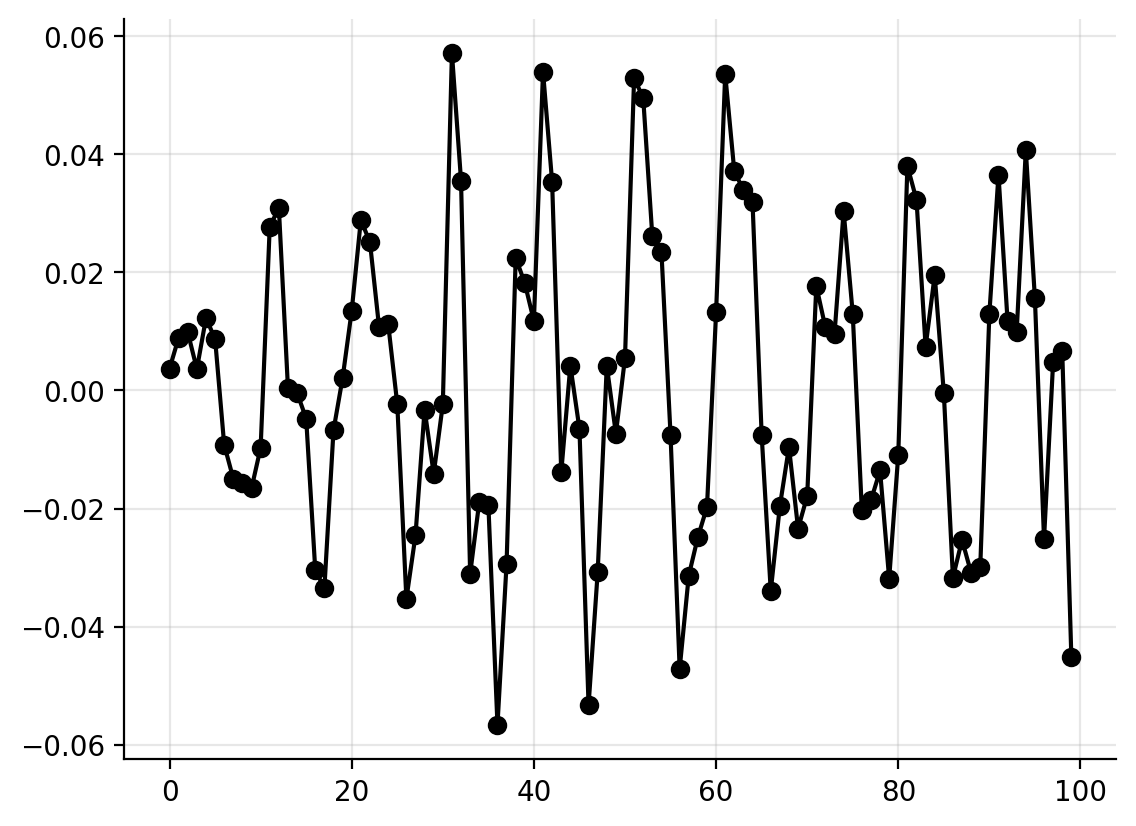

In [64]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

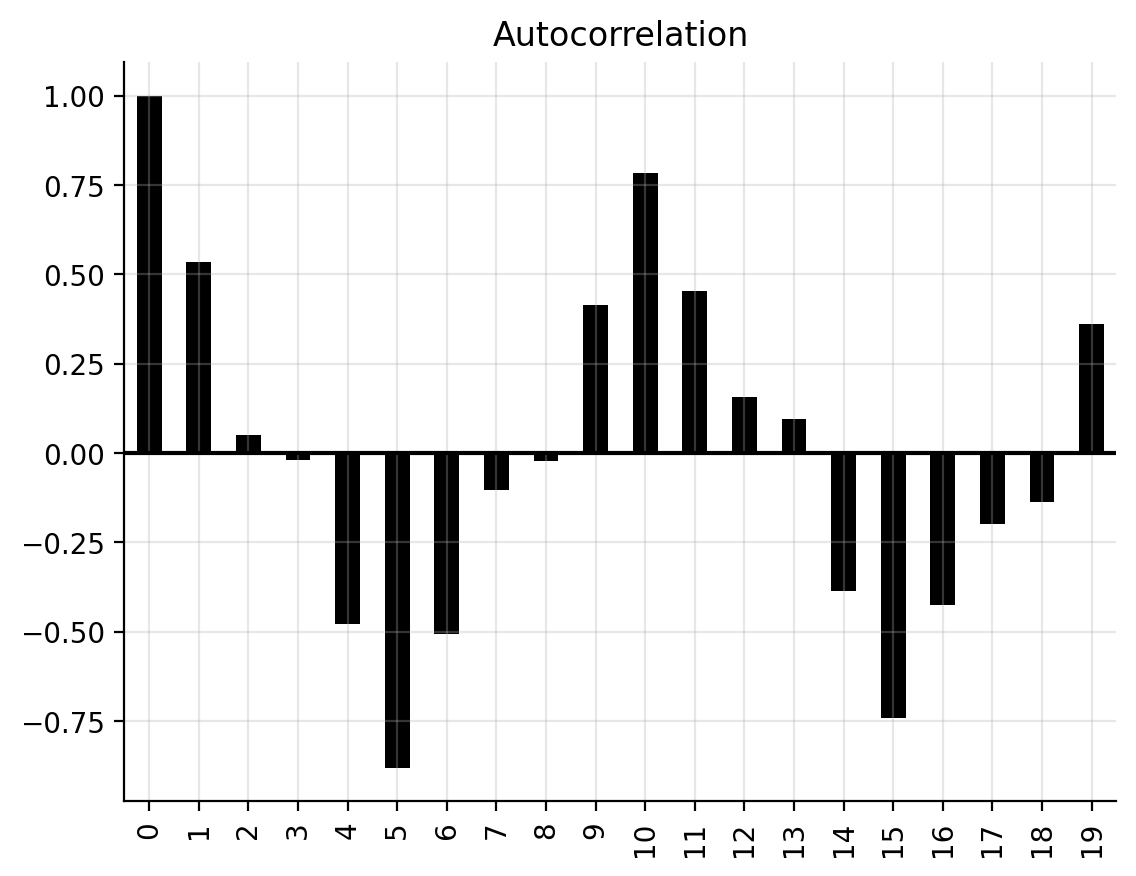

In [65]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.axhline(y=0, c="black")
plt.title("Autocorrelation")
plt.grid(alpha=0.3)